In [52]:
import librosa
import librosa.display
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import IPython
from tqdm import tqdm

In [53]:
# Calm which is present only in ravdess is ignored due to be too similiar to Neutral
# merging may cause imbalance
IGNORE_CALM = True

#Using TESS and SAVEE labeling convention
emotion_dict={
    0: 'neutral',
    1: 'happy',
    2: 'sad',
    3: 'angry',
    4: 'fearful',
    5: 'disgusted',
    6: 'surprised'
}



In [54]:
def load_dataset(dataset, df, ignore_calm=True):
    """
    Load a dataset in the df, using TESS labeling
    
    Args:
        dataset: name of the dataset, assuming is in Dataset/
        df (pd.DataFrame): emotion, file_path
     
        
    Returns:
        pd.DataFrame: update dataframe
    """
    dataset_path = 'Dataset/'+dataset
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"): 
                file_path = os.path.join(root, file)
                emotion = -1
                #RAVDESS
                if dataset == 'RAVDESS':
                    emotion = int(file.split("-")[2])-1 #to have 0-6 range
                    if ignore_calm:
                        if emotion == 1:
                            continue
                        if emotion >= 2: 
                            emotion-=1
                #CREMA            
                elif dataset == 'CREMA-D':
                    part=file.split('_')
                    if part[2] == 'SAD':
                        emotion = 2
                    elif part[2] == 'ANG':
                        emotion = 3
                    elif part[2] == 'DIS':
                        emotion = 5
                    elif part[2] == 'FEA':
                        emotion = 4
                    elif part[2] == 'HAP':
                        emotion = 1
                    elif part[2] == 'NEU':
                        emotion = 0
                    else:
                        continue
                #TESS   
                elif dataset == 'TESS':
                    part=file.split('_')
                    part[2] = part[2].removesuffix('.wav')
                    if part[2] == 'angry':
                        emotion = 3
                    elif part[2] == 'disgust':
                        emotion = 5
                    elif part[2] == 'fear':
                        emotion = 4
                    elif part[2] == 'happy':
                        emotion = 1
                    elif part[2] == 'neutral':
                        emotion = 0
                    elif part[2] == 'ps':
                        emotion = 6
                    elif part[2] == 'sad':
                        emotion = 2
                #SAVEE        
                elif dataset == 'SAVEE':
                    ele = file.split('_')[1]
                    part = ele[:-6]
                    
                    if part == 'a':
                        emotion = 3
                    elif part == 'd':
                        emotion = 5
                    elif part == 'f':
                        emotion = 4
                    elif part == 'h':
                        emotion = 1
                    elif part == 'n':
                        emotion = 0
                    elif part == 'sa':
                        emotion = 6
                    elif part == 'su':
                        emotion = 2
                     
                    
                df.loc[len(df)] = [emotion, file_path]
    return df


In [55]:
#Path to data
Ravdess = "RAVDESS"
Crema = "CREMA-D"
Tess = "TESS"
Savee = "SAVEE"

   
df = pd.DataFrame(columns=["emotion", "path"])

df = load_dataset(dataset=Ravdess, df = df)
#df = load_dataset(dataset=Crema, df = df)
#df = load_dataset(dataset=Tess, df = df)
#df = load_dataset(dataset=Savee, df = df)


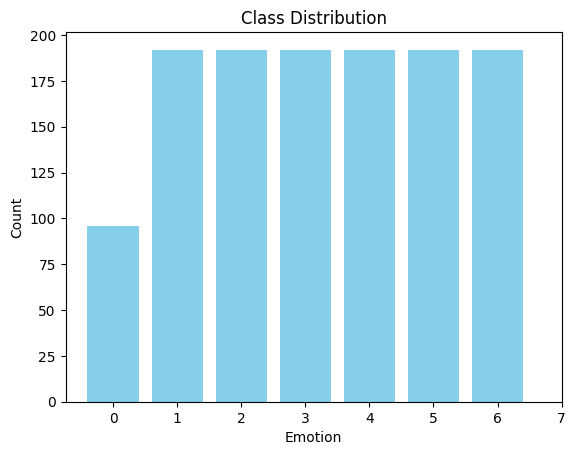

In [56]:
def plot_class_distribution(y):
    #plot the class distribution
    plt.hist(y, bins=range(8), rwidth=0.8, align='left', color='skyblue')
    plt.xticks(range(8))
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()
def plot_spectogram(spec,sr = 22050):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spec, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()
plot_class_distribution(df['emotion'])

# Extract features

In [57]:
def extract_features(audio, sr):
    features = {}
    
    # Prosodiche
    f0, voiced_flag, voiced_probs = librosa.pyin(audio, fmin=50, fmax=500)
    features["pitch_mean"] = np.nanmean(f0)
    features["pitch_std"] = np.nanstd(f0)
    features["energy_mean"] = np.mean(librosa.feature.rms(y=audio))
    features["energy_std"] = np.std(librosa.feature.rms(y=audio))
    features["zcr_mean"] = np.mean(librosa.feature.zero_crossing_rate(y=audio))
    
    # Spettrali
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f"mfcc_{i+1}_mean"] = np.mean(mfccs[i])
        features[f"mfcc_{i+1}_std"] = np.std(mfccs[i])
    
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    features["chroma_mean"] = np.mean(chroma)
    features["chroma_std"] = np.std(chroma)
    
    spec_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    features["spec_centroid_mean"] = np.mean(spec_centroid)
    features["spec_centroid_std"] = np.std(spec_centroid)
    
    spec_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)
    features["spec_bandwidth_mean"] = np.mean(spec_bandwidth)
    features["spec_bandwidth_std"] = np.std(spec_bandwidth)
    
    spec_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    features["spec_contrast_mean"] = np.mean(spec_contrast)
    features["spec_contrast_std"] = np.std(spec_contrast)
    
    spec_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)
    features["spec_rolloff_mean"] = np.mean(spec_rolloff)
    features["spec_rolloff_std"] = np.std(spec_rolloff)
    
    return features

In [ ]:
# Creazione DataFrame di training
train_data = []
for row in tqdm(df.itertuples(index=False), total=df.shape[0]):
    path = row.path
    emotion = row.emotion
    audio, sr = librosa.load(path, sr=None)  # Usa sr=None per mantenere la frequenza originale
    
    features = extract_features(audio, sr)
    features["emotion"] = emotion  # Aggiungi etichetta emozionale
    
    train_data.append(features)

# Creazione DataFrame finale
train_df = pd.DataFrame(train_data)
print(train_df.head())


## Train test split

In [61]:
train_indices, test_indices = train_test_split(
    df.index, 
    test_size=0.2, 
    random_state=44
)

train_indices, val_indices = train_test_split(
    train_indices, 
    test_size=0.125,  # 0.125* 0.8 = 10% 
    random_state=44
)

print("Train: ", len(train_indices))
print("Val: ", len(val_indices))
print("Test: ", len(test_indices))

Train:  873
Val:  125
Test:  250


In [69]:
def split_feature_label(df):
    X = df.drop(columns=["emotion"])
    y = df["emotion"]
    return X, y

This way of genereting it is done in order to avoid data leakage

In [71]:
X_train, y_train = split_feature_label(train_df.iloc[train_indices])
X_val, y_val = split_feature_label(train_df.iloc[val_indices])
X_test, y_test = split_feature_label(train_df.iloc[test_indices])

In [72]:
len(X_train), len(X_val), len(X_test)   

(873, 125, 250)

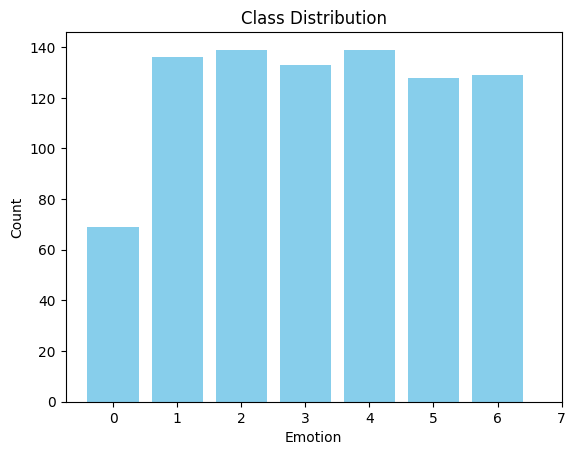

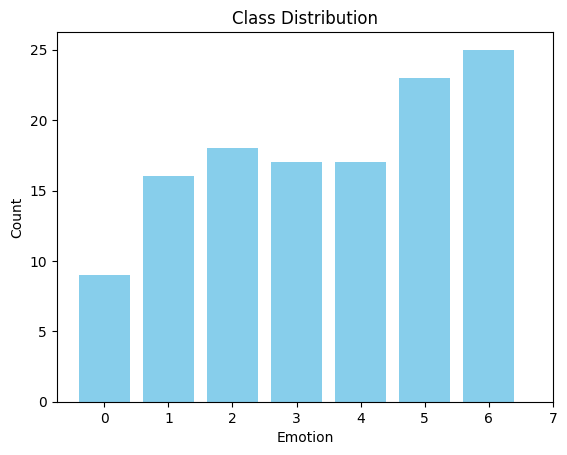

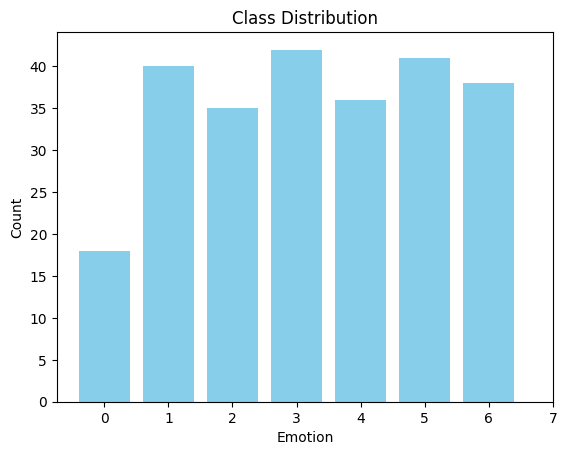

In [73]:
plot_class_distribution(y_train)
plot_class_distribution(y_val)
plot_class_distribution(y_test)

# Save dataset

In [75]:
def save_dataset(X_train, X_val, X_test, y_train, y_val, y_test, output_dir="processed_data"):
    os.makedirs(output_dir, exist_ok=True)
    np.save(os.path.join(output_dir, "fe_X_train.npy"), X_train)
    np.save(os.path.join(output_dir, "fe_X_val.npy"), X_val)
    np.save(os.path.join(output_dir, "fe_X_test.npy"), X_test)
    np.save(os.path.join(output_dir, "fe_y_train.npy"), y_train)
    np.save(os.path.join(output_dir, "fe_y_val.npy"), y_val)
    np.save(os.path.join(output_dir, "fe_y_test.npy"), y_test)

In [76]:
save_dataset(X_train, X_val, X_test, y_train, y_val, y_test)